In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, diff, solve
from scipy.interpolate import make_interp_spline

# Linear Spline Interpolation
def linear_spline(x, y, query_points):
    n = len(x) - 1  # Number of intervals
    results = []
    for qp in query_points:
        for i in range(n):
            if x[i] <= qp <= x[i + 1]:  # Find the correct interval
                m = (y[i + 1] - y[i]) / (x[i + 1] - x[i])
                c = y[i] - m * x[i]
                results.append(m * qp + c)
                break
    return np.array(results)

def quadratic_interpolation(x_data, y_data, x_new):
    """
    Perform quadratic interpolation on a set of data points and return the interpolated value.

    Parameters:
    - x_data (array-like): x-coordinates of the input data points.
    - y_data (array-like): y-coordinates of the input data points.
    - x_new (float): x-coordinate for which the interpolation is desired.

    Returns:
    - solution (dict): Coefficients of the quadratic interpolating polynomials.
    - yn (float): Interpolated y-value corresponding to x_new.
    """
    # Create the dataset
    data = np.array(list(zip(x_data, y_data)))
    n = len(data) - 1  # Number of intervals

    # Symbolic variables
    x = symbols('x')
    a = symbols(f'a1:{n+1}')
    b = symbols(f'b1:{n+1}')
    c = symbols(f'c1:{n+1}')

    # Quadratic functions for each interval
    f = [a[i] * x**2 + b[i] * x + c[i] for i in range(n)]

    # Equations
    equations = []

    # Interpolation constraints
    equations.append(f[0].subs(x, data[0, 0]) - data[0, 1])
    for i in range(n - 1):
        equations.append(f[i].subs(x, data[i+1, 0]) - data[i+1, 1])
        equations.append(f[i+1].subs(x, data[i+1, 0]) - data[i+1, 1])
    equations.append(f[-1].subs(x, data[-1, 0]) - data[-1, 1])

    # First derivative continuity
    f_prime = [diff(f[i], x) for i in range(n)]
    for i in range(n - 1):
        equations.append(f_prime[i].subs(x, data[i+1, 0]) - f_prime[i+1].subs(x, data[i+1, 0]))

    # Boundary condition: Second derivative at the last point is zero
    equations.append(a[-1])

    # Solve the equations
    solution = solve(equations, a + b + c)

    # Find interpolated value at x_new
    yn = None
    for i in range(n):
        if data[i, 0] <= x_new <= data[i+1, 0]:
            f_i = f[i].subs(solution)
            yn = f_i.subs(x, x_new)
            break

    if yn is None:
        print("The value is out of bounds.")
        return solution, None

    return solution, float(yn)


# Cubic Spline Interpolation (from scratch)
def cubic_spline(x, y, x_eval):
    n = len(x) - 1
    h = np.diff(x)
    alpha = [3 / h[i] * (y[i + 1] - y[i]) - 3 / h[i - 1] * (y[i] - y[i - 1]) for i in range(1, n)]

    l = np.ones(n + 1)
    mu = np.zeros(n)
    z = np.zeros(n + 1)

    for i in range(1, n):
        l[i] = 2 * (x[i + 1] - x[i - 1]) - h[i - 1] * mu[i - 1]
        mu[i] = h[i] / l[i]
        z[i] = (alpha[i - 1] - h[i - 1] * z[i - 1]) / l[i]

    b, c, d = np.zeros(n), np.zeros(n + 1), np.zeros(n)
    for i in range(n - 1, -1, -1):
        c[i] = z[i] - mu[i] * c[i + 1]
        b[i] = (y[i + 1] - y[i]) / h[i] - h[i] * (c[i + 1] + 2 * c[i]) / 3
        d[i] = (c[i + 1] - c[i]) / (3 * h[i])

    # Evaluate cubic spline
    y_eval = np.zeros_like(x_eval)
    for i in range(n):
        mask = (x_eval >= x[i]) & (x_eval <= x[i + 1])
        dx = x_eval[mask] - x[i]
        y_eval[mask] = y[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3
    return y_eval

# SciPy Spline (for comparison)
def scipy_spline(x, y, x_eval, order):
    spline = make_interp_spline(x, y, k=order)
    return spline(x_eval)

# Plotting Function
def plot_splines(x, y, x_high_res, y_linear, y_quadratic, y_cubic, y_cubic_scipy):
    plt.figure(figsize=(12, 8))
    plt.plot(x, y, 'o', label='Data Points', color='black')
    plt.plot(x_high_res, y_linear, '-', label='Linear Spline', color='blue')
    plt.plot(x_high_res, y_quadratic, '-', label='Quadratic Spline', color='green')
    plt.plot(x_high_res, y_cubic, '-', label='Cubic Spline (Scratch)', color='red')
    plt.plot(x_high_res, y_cubic_scipy, ':', label='Cubic Spline (SciPy)', color='orange')
    plt.title('Comparison of Splines')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()



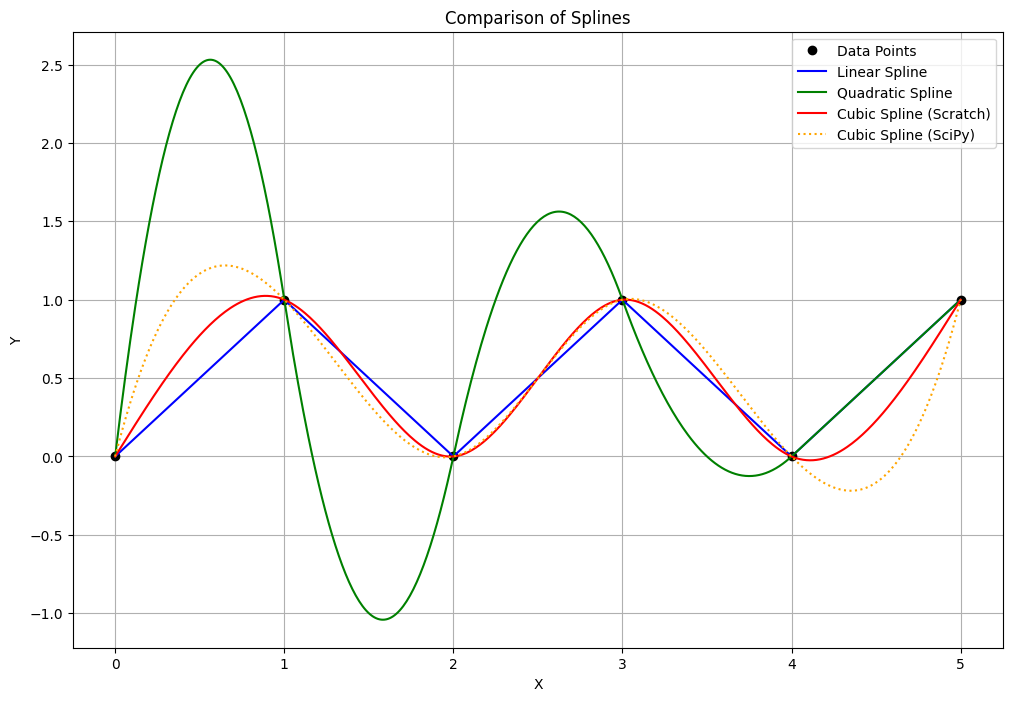

In [42]:

# Main execution
if __name__ == "__main__":
    # Sample data points
    x = np.array([0, 1, 2, 3, 4, 5])
    y = np.array([0, 1, 0, 1, 0, 1])

    # High-resolution x-axis for smooth plotting
    x_high_res = np.linspace(x.min(), x.max(), 500)

    # Interpolations
    y_linear = linear_spline(x, y, x_high_res)
    y_quadratic = np.array([quadratic_interpolation(x, y, xi)[1] for xi in x_high_res])  # Get the y-values from quadratic interpolation
    y_cubic = cubic_spline(x, y, x_high_res)
    y_cubic_scipy = scipy_spline(x, y, x_high_res, 3)

    # Plot the results for all splines in one plot
    plot_splines(x, y, x_high_res, y_linear, y_quadratic, y_cubic, y_cubic_scipy)


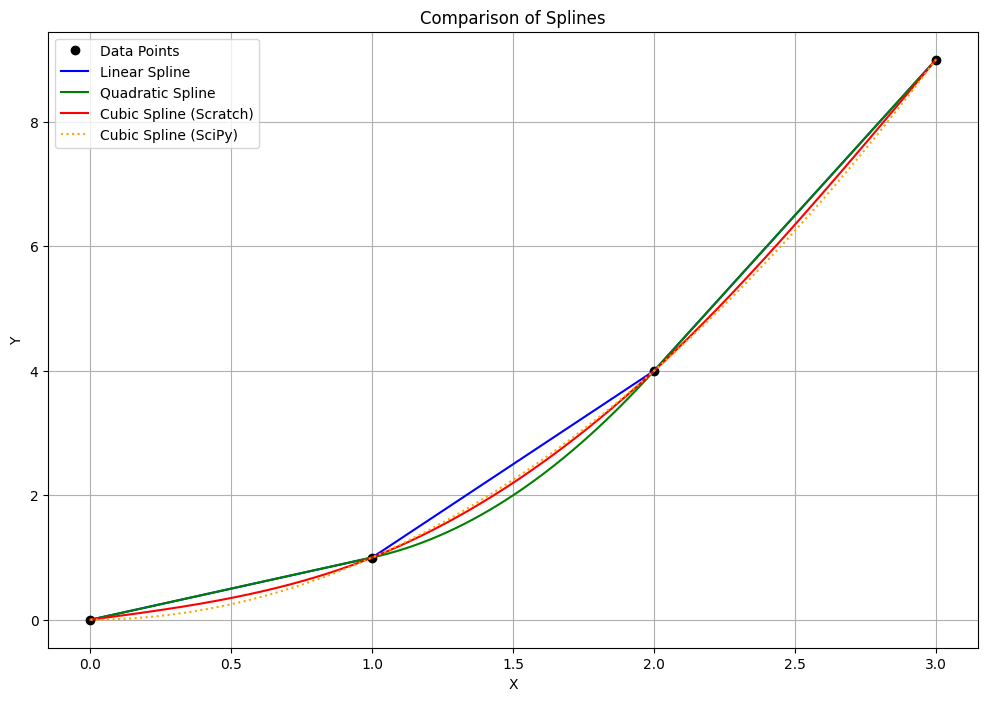

In [44]:

# Main execution
if __name__ == "__main__":
    # Sample data points
    x = np.array([0, 1, 2, 3])
    y = np.array([0, 1, 4, 9])

    # High-resolution x-axis for smooth plotting
    x_high_res = np.linspace(x.min(), x.max(), 500)

    # Interpolations
    y_linear = linear_spline(x, y, x_high_res)
    y_quadratic = np.array([quadratic_interpolation(x, y, xi)[1] for xi in x_high_res])  # Get the y-values from quadratic interpolation
    y_cubic = cubic_spline(x, y, x_high_res)
    y_cubic_scipy = scipy_spline(x, y, x_high_res, 3)

    # Plot the results for all splines in one plot
    plot_splines(x, y, x_high_res, y_linear, y_quadratic, y_cubic, y_cubic_scipy)


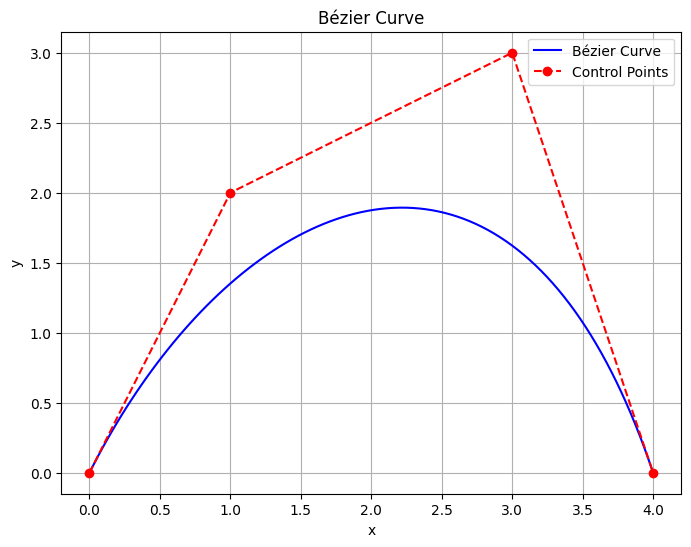

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def bezier_curve(control_points, num_points=100):
    """
    Calculate a Bézier curve using the De Casteljau algorithm.

    Args:
    - control_points (list of tuples): Control points as (x, y) coordinates.
    - num_points (int): Number of points to calculate along the curve.

    Returns:
    - curve (list of tuples): Points along the Bézier curve.
    """
    def de_casteljau(points, t):
        """
        Perform De Casteljau's algorithm recursively.

        Args:
        - points (list of tuples): Current control points.
        - t (float): Parameter between 0 and 1.

        Returns:
        - point (tuple): The calculated point on the Bézier curve at parameter t.
        """
        if len(points) == 1:
            return points[0]
        new_points = [
            ((1 - t) * p0[0] + t * p1[0], (1 - t) * p0[1] + t * p1[1])
            for p0, p1 in zip(points[:-1], points[1:])
        ]
        return de_casteljau(new_points, t)

    curve = [de_casteljau(control_points, t) for t in np.linspace(0, 1, num_points)]
    return curve

# Example usage
if __name__ == "__main__":
    # Define control points
    control_points = [(0, 0), (1, 2), (3, 3), (4, 0)]

    # Calculate Bézier curve
    curve_points = bezier_curve(control_points)

    # Plotting the curve
    control_x, control_y = zip(*control_points)
    curve_x, curve_y = zip(*curve_points)

    plt.figure(figsize=(8, 6))
    plt.plot(curve_x, curve_y, label="Bézier Curve", color="blue")
    plt.plot(control_x, control_y, "o--", label="Control Points", color="red")
    plt.legend()
    plt.title("Bézier Curve")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()


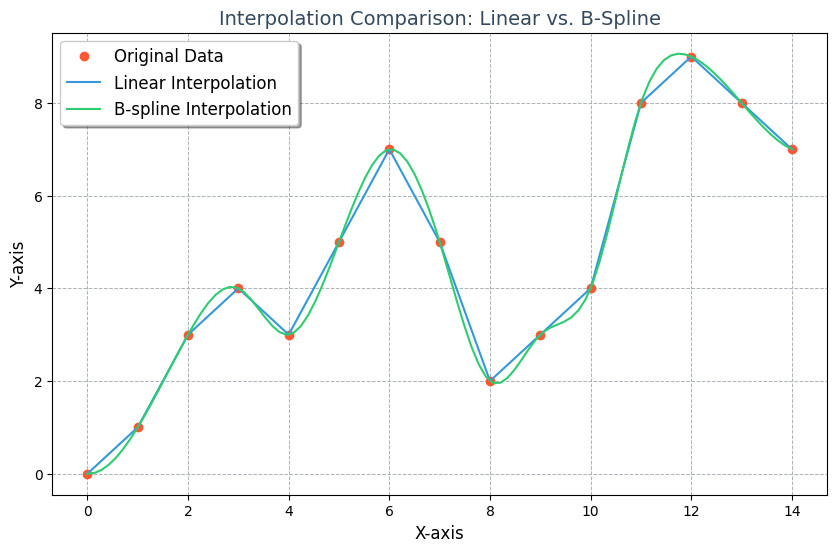

In [4]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np

# Sample data points
y = [0, 1, 3, 4, 3, 5, 7, 5, 2, 3, 4, 8, 9, 8, 7]
n = len(y)
x = range(0, n)

# Generate B-spline representation
tck = interpolate.splrep(x, y, s=0, k=3)

# Generate smoother curve
x_new = np.linspace(min(x), max(x), 100)
y_fit = interpolate.BSpline(*tck)(x_new)

# Plot both graphs in a single figure
plt.figure(figsize=(10, 6))

# Original data
plt.plot(x, y, 'o', color="#FF5733", label="Original Data")  # Orange-red
# Linear interpolation
plt.plot(x, y, '-', color="#3498DB", label="Linear Interpolation")  # Blue
# B-spline interpolation
plt.plot(x_new, y_fit, '-', color="#2ECC71", label="B-spline Interpolation")  # Green

# Add labels, legend, and grid
plt.title("Interpolation Comparison: Linear vs. B-Spline", fontsize=14, color="#34495E")  # Dark slate
plt.legend(loc='best', fancybox=True, shadow=True, fontsize=12)
plt.grid(color="#ABB2B9", linestyle='--', linewidth=0.7)  # Gray
plt.xlabel("X-axis", fontsize=12)
plt.ylabel("Y-axis", fontsize=12)

# Display the plot
plt.show()


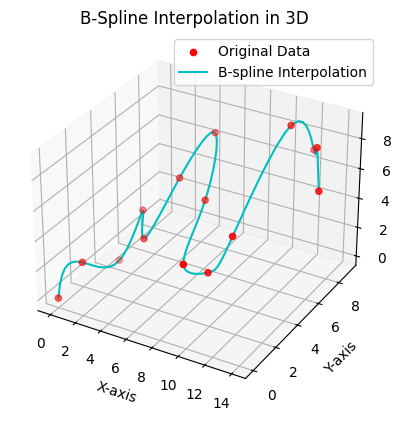

In [3]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np

# Original data points in 3D
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
y = [0, 1, 3, 4, 3, 5, 7, 5, 2, 3, 4, 8, 9, 8, 7]
z = [0, 2, 1, 4, 3, 6, 8, 5, 3, 2, 4, 9, 7, 8, 6]

# Parametric variable
t = np.arange(len(x))

# Number of points for smooth curve
num_points = 100

# Perform B-spline interpolation for x, y, and z
tck_x = interpolate.splrep(t, x, s=0, k=3)
tck_y = interpolate.splrep(t, y, s=0, k=3)
tck_z = interpolate.splrep(t, z, s=0, k=3)

# Generate new parametric values
t_new = np.linspace(t[0], t[-1], num_points)

# Interpolated data points
x_new = interpolate.BSpline(*tck_x)(t_new)
y_new = interpolate.BSpline(*tck_y)(t_new)
z_new = interpolate.BSpline(*tck_z)(t_new)

# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r', marker='o', label="Original Data")
ax.plot(x_new, y_new, z_new, '-c', label="B-spline Interpolation")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.title("B-Spline Interpolation in 3D")
plt.legend()
plt.show()


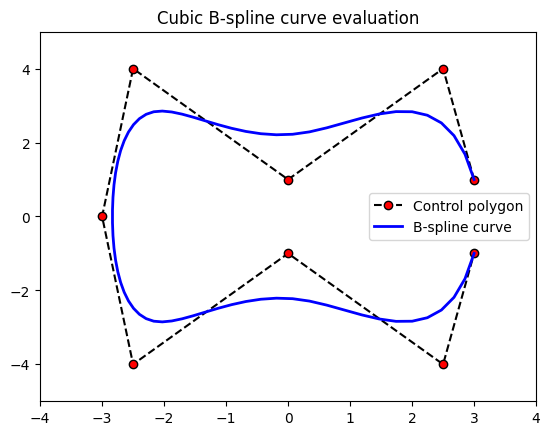

In [9]:

import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt


ctr =np.array( [(3 , 1), (2.5, 4), (0, 1), (-2.5, 4),
                (-3, 0), (-2.5, -4), (0, -1), (2.5, -4), (3, -1),])
x=ctr[:,0]
y=ctr[:,1]

# uncomment both lines for a closed curve
# x=np.append(x,[x[0]])
# y=np.append(y,[y[0]])

l=len(x)

t=np.linspace(0,1,l-2,endpoint=True)
t=np.append([0,0,0],t)
t=np.append(t,[1,1,1])

tck=[t,[x,y],3]
u3=np.linspace(0,1,(max(l*2,70)),endpoint=True)
out = interpolate.splev(u3,tck)

plt.plot(x,y,'k--',label='Control polygon',marker='o',markerfacecolor='red')
#plt.plot(x,y,'ro',label='Control points only')
plt.plot(out[0],out[1],'b',linewidth=2.0,label='B-spline curve')
plt.legend(loc='best')
plt.axis([min(x)-1, max(x)+1, min(y)-1, max(y)+1])
plt.title('Cubic B-spline curve evaluation')
plt.show()

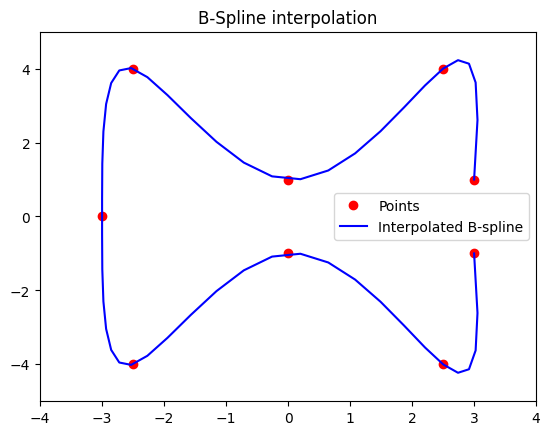

In [10]:
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt

#x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
#y = np.sin(x)

ctr =np.array( [(3 , 1), (2.5, 4), (0, 1), (-2.5, 4),
                (-3, 0), (-2.5, -4), (0, -1), (2.5, -4), (3, -1)])

x=ctr[:,0]
y=ctr[:,1]

#x=np.append(x,x[0])
#y=np.append(y,y[0])

tck,u = interpolate.splprep([x,y],k=3,s=0)
u=np.linspace(0,1,num=50,endpoint=True)
out = interpolate.splev(u,tck)

plt.figure()
plt.plot(x, y, 'ro', out[0], out[1], 'b')
plt.legend(['Points', 'Interpolated B-spline', 'True'],loc='best')
plt.axis([min(x)-1, max(x)+1, min(y)-1, max(y)+1])
plt.title('B-Spline interpolation')
plt.show()